# CoCoScore Implementation

This notebook consists of implementing the [CoCoScore](https://www.biorxiv.org/content/10.1101/444398v1) literature model for comparison.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from collections import defaultdict
import os
import sys

sys.path.append(os.path.abspath('../../../../modules'))

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, f1_score, precision_recall_curve, accuracy_score, confusion_matrix
from tqdm import tqdm_notebook

In [2]:
from utils.notebook_utils.dataframe_helper import load_candidate_dataframes

In [3]:
total_candidates_df = pd.read_csv("input/all_cbg_candidates.tsv.xz", sep="\t")
total_candidates_df.head(2)

,entrez_gene_id,gene_symbol,drugbank_id,name,sources,hetionet,n_sentences,has_sentence,partition_rank,split,candidate_id,sentence_id,text,sen_length
0,1,A1BG,DB00117,L-Histidine,NaN,0,1,1,0.37753,6,33517095,94389805,"Thus, as the assessment of protein glycosylati...",92
1,1,A1BG,DB00143,Glutathione,NaN,0,1,1,0.30352,6,28913100,83523801,Similar observations were made in T98 glioma c...,33


In [4]:
spreadsheet_names = {
    'dev': '../../data/sentences/sentence_labels_dev.xlsx',
    'test': '../../data/sentences/sentence_labels_test.xlsx'
}

In [5]:
candidate_dfs = {
    key:load_candidate_dataframes(spreadsheet_names[key], "curated_cbg")
    for key in spreadsheet_names
}

for key in candidate_dfs:
    print("Size of {} set: {}".format(key, candidate_dfs[key].shape[0]))

Size of dev set: 500
Size of test set: 500


In [6]:
distant_supervision_marginals = pd.read_csv("input/baseline_sampled.tsv.xz", sep="\t")
distant_supervision_marginals.head(2)

,"0:0,1,2,3,4,5,6,7,8",candidate_id
0,0.032877,50493
1,0.000763,50500


In [7]:
all_embedded_cg_df = pd.read_csv("input/all_embedded_cg_sentences.tsv.xz", sep="\t").drop_duplicates()
all_embedded_cg_df.head(2)

,0,1,2,3,4,5,6,7,8,9,...,52,53,54,55,56,57,58,59,candidate_id,sen_length
0,335,5,193,8,163,131,246,35,2034,37,...,0,0,0,0,0,0,0,0,50493,17
1,18,525,17,647,14,529,156,29,35,36296,...,0,0,0,0,0,0,0,0,50494,27


In [8]:
word_dict = pd.read_csv("input/compound_binds_gene_word_dict.tsv", sep="\t").assign(index=lambda x: x.index + 2)
word_dict.head()

,word,index
0,serum,2
1,hormone,3
2,(,4
3,~~[[2,5
4,amh,6


In [9]:
reverse_word_dict = dict(zip(word_dict['index'].values.tolist(), word_dict.word))

train_marginal_dict = dict(zip(
    distant_supervision_marginals.candidate_id, 
    distant_supervision_marginals[distant_supervision_marginals.columns[0]]
))

tune_marginal_dict = dict(zip(
    candidate_dfs['dev'].candidate_id.values,
    candidate_dfs['dev'].curated_cbg.values
))


test_marginal_dict = dict(zip(
    candidate_dfs['test'].candidate_id.values,
    candidate_dfs['test'].curated_cbg.values
))

In [10]:
data_rows = []
entity_one_start = word_dict.query("word=='~~[[1'")['index'].values[0]
entity_one_end = word_dict.query("word=='1]]~~'")['index'].values[0]

entity_two_start = word_dict.query("word=='~~[[2'")['index'].values[0]
entity_two_end = word_dict.query("word=='2]]~~'")['index'].values[0]

with open("output/optimization_data/training.txt", "w") as train:
    with open("output/optimization_data/tune.txt", "w") as tune:
        with open("output/optimization_data/test.txt", "w") as test:
            with open("output/all_cg_sentences.txt", "w") as all_sen:
                for idx, sen_df in tqdm_notebook(all_embedded_cg_df.iterrows()):
                    sen = sen_df.iloc[:-2].tolist()
                    
                    try:
                        # remove entity mentions for coco_score
                        del sen[sen.index(entity_one_start): sen.index(entity_one_end)+1]
                        del sen[sen.index(entity_two_start): sen.index(entity_two_end)+1]

                        embedded_sen = list(map(
                            lambda x: reverse_word_dict[x] if x in reverse_word_dict else "UNK" if x == 1 else "",
                            sen
                        ))

                        cand_id = int(sen_df.iloc[-2])
                        if cand_id in train_marginal_dict:
                            train.write(
                                f"__label__{'1' if train_marginal_dict[cand_id]> 0.5 else '0'}\t" +
                                "\t".join(embedded_sen)+ 
                                "\n"
                            )
                        if cand_id in tune_marginal_dict:
                            tune.write(
                                f"__label__{int(tune_marginal_dict[cand_id])}\t" +
                                "\t".join(embedded_sen)+ 
                                "\n"
                            )
                        if cand_id in test_marginal_dict:
                            test.write(
                                f"__label__{int(test_marginal_dict[cand_id])}\t" +
                                "\t".join(embedded_sen)+ 
                                "\n"
                            )

                        all_sen.write(
                                f"__label__{cand_id}\t" +
                                "\t".join(embedded_sen) + 
                                "\n"
                            )

                    except ValueError:
                        print(idx)

/home/danich1/.local/lib/python3.6/site-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


In [11]:
os.system(
    "../../../../../fastText/fasttext supervised " + 
    "-input output/optimization_data/training.txt -output output/cbg_model " +
    "-lr 0.005 -epoch 50 -dim 300 -wordNgrams 2" 
)

os.system(
    "../../../../../fastText/fasttext predict-prob "+
    "output/cbg_model.bin output/optimization_data/tune.txt "+
    " > output/optimized_predictions/tune_predictions.tsv"
)

os.system(
    "../../../../../fastText/fasttext predict-prob "+
    "output/cbg_model.bin output/optimization_data/test.txt "+
    " > output/optimized_predictions/test_predictions.tsv"
)

0

In [12]:
tune_df = (
    pd.read_csv(
        'output/optimized_predictions/tune_predictions.tsv', 
        header=None, sep=" ", 
        names=["label", "pred"]
    )
    .assign(label=lambda x: x.label.apply(lambda sen: sen[-1]))
)

precision, recall, _ = precision_recall_curve(
    tune_df.label.astype(int).values,
    1-tune_df.pred.values
)
auc(recall, precision)

0.21675324675324675

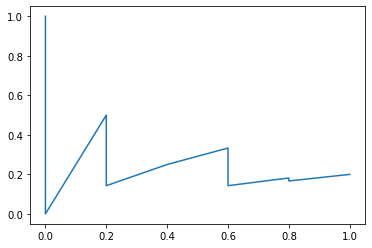

In [13]:
plt.plot(recall, precision)

In [14]:
fpr, tpr, _ = roc_curve(
    tune_df.label.astype(int).values,
    1-tune_df.pred.values
)
auc(fpr, tpr)

0.9758293838862558

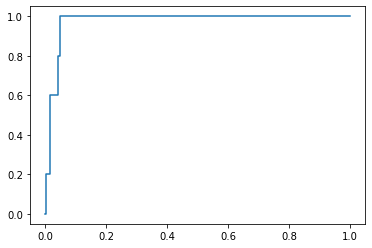

In [15]:
plt.plot(fpr, tpr)

In [16]:
os.system(
    "../../../../../fastText/fasttext predict-prob "+
    "output/cbg_model.bin output/all_cg_sentences.txt "+
    "> output/all_cg_sentences_predictions.tsv"
)

0

In [17]:
predictions_df = (
    pd.read_csv(
        "output/all_cg_sentences_predictions.tsv", 
        header=None, sep=" ",
        names=["label", "coco_pred"]
    )
    .assign(candidate_id=all_embedded_cg_df.candidate_id.values.tolist())
    .assign(coco_pred=lambda x: 1 - x.coco_pred)
    .assign(coco_pred=lambda x: x.coco_pred.clip(0,1) + 1e-5)
)
predictions_df.head(2)

,label,coco_pred,candidate_id
0,__label__0,0.000407,50493
1,__label__0,0.004035,50494


In [18]:
final_pred_df = (
    total_candidates_df
    [["entrez_gene_id", "drugbank_id", "candidate_id"]]
    .merge(predictions_df[["coco_pred", "candidate_id"]])
)
final_pred_df.head(2)

,entrez_gene_id,drugbank_id,candidate_id,coco_pred
0,1,DB00143,28913100,0.326116
1,1,DB00145,33537346,0.027294


In [19]:
added_scores_df = (
    final_pred_df
    .groupby(["entrez_gene_id", "drugbank_id"])
    .aggregate({"coco_pred": 'sum'})
    .reset_index()
)
added_scores_df.head(2)

,entrez_gene_id,drugbank_id,coco_pred
0,1,DB00143,0.326116
1,1,DB00145,0.027294


In [20]:
total_score = added_scores_df.coco_pred.sum()
gene_scores = added_scores_df.groupby("entrez_gene_id").agg({"coco_pred":"sum"}).reset_index()
gene_scores = dict(zip(gene_scores.entrez_gene_id, gene_scores.coco_pred))
drug_scores = added_scores_df.groupby("drugbank_id").agg({"coco_pred":"sum"}).reset_index()
drug_scores = dict(zip(drug_scores.drugbank_id, drug_scores.coco_pred))

alpha=0.65

final_scores_df = added_scores_df.assign(
    final_score=(
        added_scores_df.apply(
            lambda x: pd.np.exp(
                    alpha*pd.np.log(x['coco_pred']) + (1-alpha)*(
                    pd.np.log(x['coco_pred']) + pd.np.log(total_score) - 
                    pd.np.log(gene_scores[x['entrez_gene_id']]) - pd.np.log(drug_scores[x['drugbank_id']])
                )
            ), 
            axis=1
        )
    )
)
final_scores_df.head(2)

,entrez_gene_id,drugbank_id,coco_pred,final_score
0,1,DB00143,0.326116,0.842150
1,1,DB00145,0.027294,0.417873


In [21]:
score_with_labels_df = (
    final_scores_df
    .merge(
        total_candidates_df[["drugbank_id", "entrez_gene_id", "hetionet"]],
        on=["drugbank_id", "entrez_gene_id"]
    )
    .drop_duplicates()
)
score_with_labels_df.head(2)

,entrez_gene_id,drugbank_id,coco_pred,final_score,hetionet
0,1,DB00143,0.326116,0.842150,0
1,1,DB00145,0.027294,0.417873,0


In [22]:
(
    score_with_labels_df
    .drop("coco_pred", axis=1)
    .rename({"final_score": "coco_score"})
    .to_csv("output/cg_edge_prediction_cocoscore.tsv", sep="\t", index=False)
)

In [23]:
fpr, tpr, _ = roc_curve(score_with_labels_df.hetionet, score_with_labels_df.final_score)
print(auc(fpr, tpr))

precision, recall, _ = precision_recall_curve(score_with_labels_df.hetionet, score_with_labels_df.final_score)
print(auc(recall, precision))

0.8418052403058354
0.22192615186075526
